# Dynamical Systems Package

Note: These functions and files as currently described will work with those found in the branch titled "colby" and "ethan," not "main."

These two files must be included at the start of the file in order to import the correct packages being used and define the correct types and functions. In the "TypeRDS.jl" file, there are descriptions on how to define the Random Dynamical Systems (RDS) type being used below, along with methods to sample from them such as sampleTraj.

In [11]:
include("rds.jl")
include("graphics.jl")

sampling

We now begin to use some of the defined packages above to get the code compiled on basic inputs. We will explore each of these functions on specific examples below, but this block ensures that the compilation is completed for all of our currently implemented functions so that they can be run much faster throughout the rest of the Notebook.

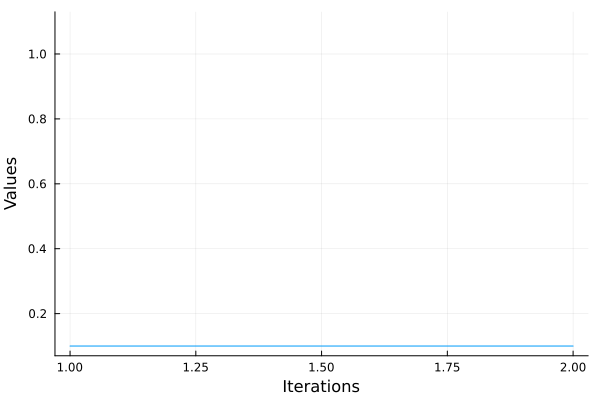

┌ Info: Saved animation to C:\Users\littl\AppData\Local\Temp\jl_ZS3WVATUli.gif
└ @ Plots C:\Users\littl\.julia\packages\Plots\tDI0A\src\animation.jl:156


Float64[]

In [12]:
function run()
    f(ω, x) = x
    p(x) = x
    rds = RDS(Interval{Closed, Closed}(0,1), 1 , Normal())
    fω(.3, [1], f)
    x=sampleTraj(rds, 1, [.1], f)
    timeseries(x, p)
    empiricalAverage(x)
    testing(x)
    tracking(x)
    sampling(1, Normal())
end
run()

The main goal is to build a Julia package that is capable of running simulations, or samples, of random dynamical systems. The core of our package is our `Type RDS`, which will contain all  necessary information related to our random dynamical system. Below is how one instantiates a `Type RDS`.

In the first implementation, our phase space $M$ is where we intend our results to lie within some interval subset of $\R$. An example construction is above, where Interval{Closed, Closed}(0,1) = [0, 1]. Next, the SampleSpaceDimension parameter indicates the dimension from which our samples will be drawn from. For example, if SampleSpaceDimension = 3, we will be drawing three real numbers ordered as a vector in $\R^{3}$ as our sample. Finally, the LawOfSamples parameter indicates from which distribution we will be drawing our sample from. In the above example, the SND was used, but we intend to allow users to evolve their systems from whichever distribution they prefer. Additionally, it could be possible for users to define their own distributions as long as they follow the same formatting and requirements described in the "Distributions.jl" package. There may be future ideas regarding removing the type restriction from this parameter, but this should work for now.

Note that the second implementation is essentially the same as the first, with the main difference being the use of $lM$ and $uM$ as the lower and upper bounds, respectively, for $M$ instead of an interval range. The other two parameters are the same. Both of these constructors could be useful for the user, so for now we are working with both.

In [13]:
struct RDS1
    M::Interval                 # Phase Space M.
    SampleSpaceDimension::Int   # Dimesnion of Ω₀    
    LawOfSamples::Distribution  # Distribution of Ω₀
end

struct RDS2
    lM::Float64                 # Lower bound of phase space M.
    uM::Float64                 # Upper phase space M.
    SampleSpaceDimension::Int   # Dimesnion of Ω₀    
    LawOfSamples::Distribution  # Distribution of Ω₀
end

rds1 = RDS1(Interval{Closed, Closed}(0,1), 1, Normal())
rds2 = RDS2(0, 1, 1, Normal())

RDS2(0.0, 1.0, 1, Normal{Float64}(μ=0.0, σ=1.0))

When evaluating our random dynamical system over time, it is common for our initial data vector, $X_0$, to be sampled from a distribution. Below shows initial data vectors sampled from different distributions. We know that the SLLN should hold for this distributions as we take a larger number of samples, and we see that it indeed does approach the true values for each of their respective PDF's. We are doing this using method `sampling(n, dist)`, which takes `n` samples from distribution `dist` over the interval $[0,1]$ and plots the resulting histogram over this interval.

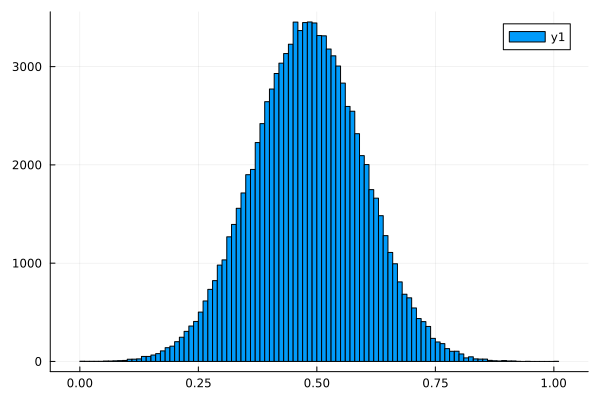

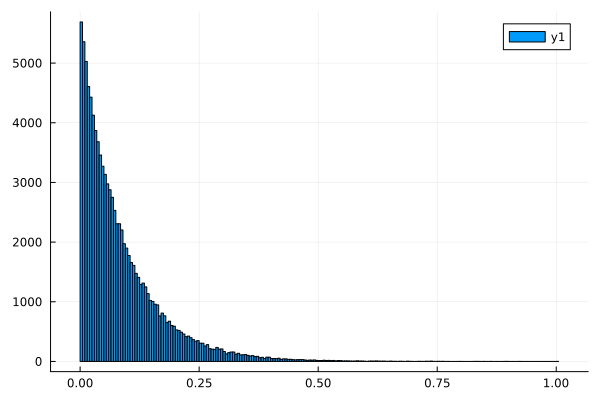

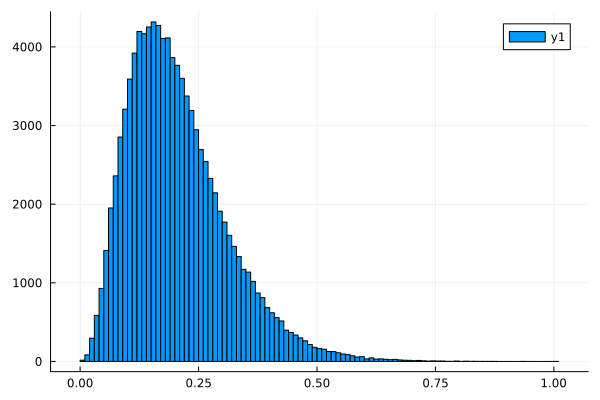

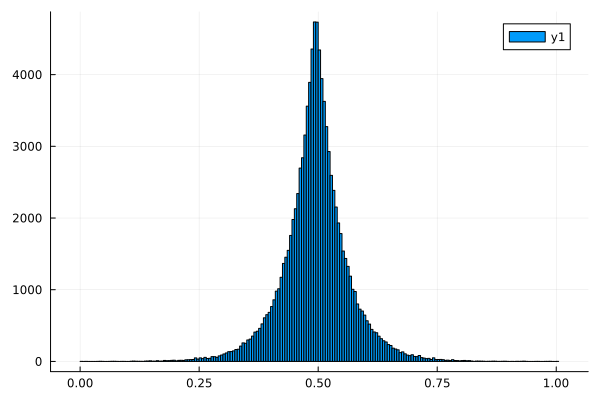

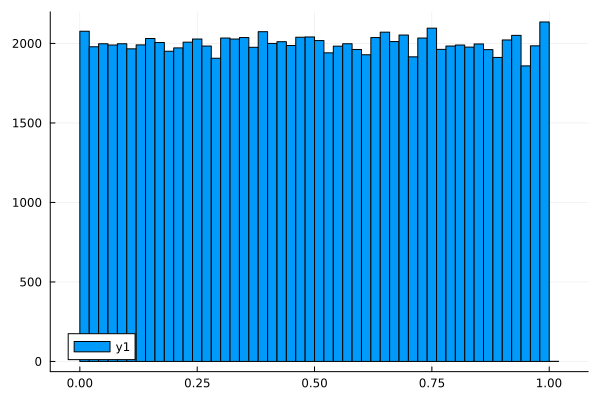

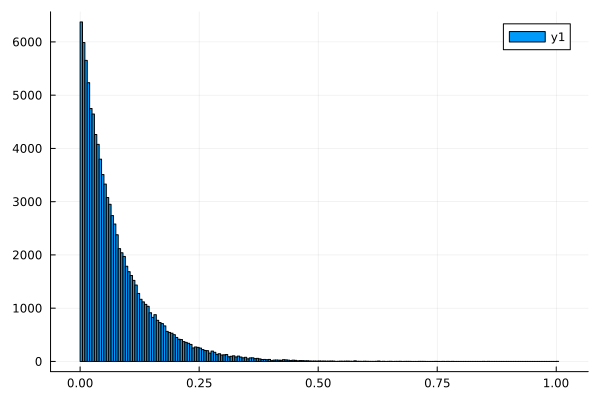

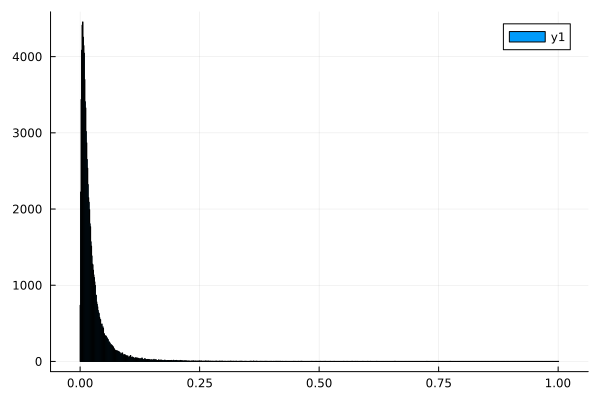

In [14]:
distributions = [Normal(), Exponential(), Chisq(8), Laplace(), Beta(), Erlang(), LogNormal()]
for dist in distributions
    display(histogram(sampling(100000, dist)))
end

As far as evolving our initial data overtime, we will be interested in the following composition:
$$f^n = f_{\omega_n} \circ \cdots \circ f_{\omega_1}: M \to M$$
where $f: \Omega_0 \times M \to M, (\omega, x) \mapsto f_\omega(x)$. If the $\omega_i$ are IID, then the sequence of random variables
$$X_n = f_{\omega_n}(X_{n-1})$$
forms a Markov chain on M. $f_{\omega_i}$ is what is moving our random dynamical system forward. For example, let $X_0 = [0.1, 0.2, 0.3]$ and $f(\omega, x) = (x + \omega) \pmod{1}$. If $\omega$ is sampled to be 2.5, then  
$$X_1 = X_0 + 2.5 \text{ (mod 1)} = X_0 + 0.5 =  [.6, .7, .8].$$



## Sampling
It would be helpful to have a method that samples a trajectory of a RDS through n iterations. That is what `sampleTraj` is used for. It takes in four parameters:
- `System::RDS` - Our random dynamical system.
- `n::Int64` - Length of wanted trajectory.
- `x0` - Initial data vector.
- `func::Function` - $f_\omega$

Here are some sample traejctory demos using the same distributions as above. After we run `sampleTraj`, we will run a method `tracking` which will produce a gif displaying the evolution of our system!

┌ Info: Saved animation to C:\Users\littl\AppData\Local\Temp\jl_xyTUJKt4LK.gif
└ @ Plots C:\Users\littl\.julia\packages\Plots\tDI0A\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\littl\\AppData\\Local\\Temp\\jl_xyTUJKt4LK.gif")
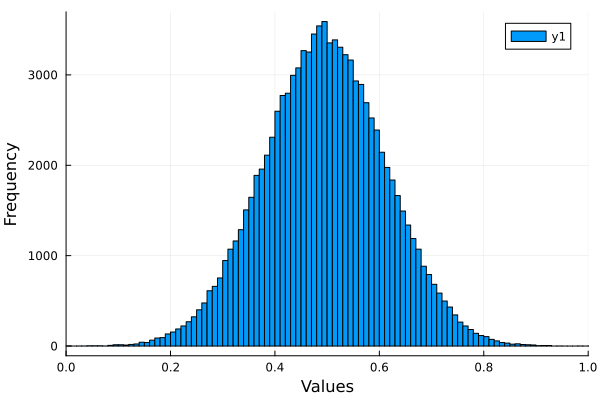

In [15]:
x0 = sampling(100000, Normal())
rds = RDS(Interval{Closed, Closed}(0,1), 1, Normal())

function f(ω::Float64, x::Float64)
    return mod(ω, 1) * x
end

traj = sampleTraj(rds, 10, x0, f)
tracking(traj)

This analytically checks out! Starting with $X_0$, every value is multiplied by the constant $0 < \omega$ mod $1<1$. So 
$$X_1 \sim \text{Norm}(c\mu, c^2\sigma^2)$$ 
where $c = \omega$ mod 1. So we expect our mean and standard deviation to decrease. As $n \to \infty,$ we have $X_n = 0.$ 

Our next example deals with the function $f(\omega, x) = x + (\frac{\omega \text{ mod } 1}{5})$. What do we expect this function to do? Since $\omega \text{ mod } 1 > 0,$ we expect our distribution to shift to the right (mod our phase space). Dividing by 5 makes the visualization nicer (assures not too large of leaps between states). What would you expect to occur when we use the function $g(\omega, x) = x - (\frac{\omega \text{ mod } 1}{5}) $ instead?



┌ Info: Saved animation to C:\Users\littl\AppData\Local\Temp\jl_BepcXod2rm.gif
└ @ Plots C:\Users\littl\.julia\packages\Plots\tDI0A\src\animation.jl:156


Plots.AnimatedGif("C:\\Users\\littl\\AppData\\Local\\Temp\\jl_BepcXod2rm.gif")
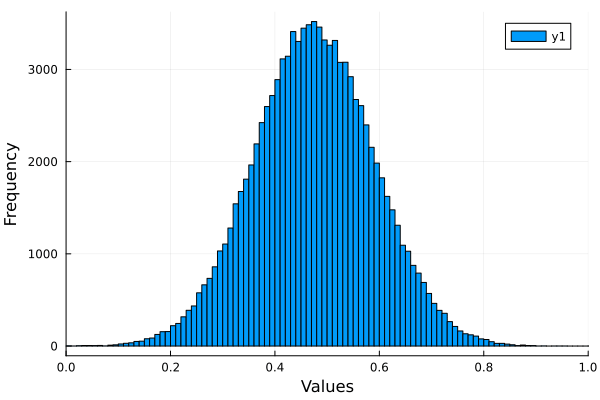

In [16]:
x0 = sampling(100000, Normal())
rds = RDS(Interval{Closed, Closed}(0,1), 1, Normal())

function f(ω::Float64, x::Float64)
    return x + (mod(ω, 1) / 5)
end

traj = sampleTraj(rds, 20, x0, f)
tracking(traj)

Let $\phi: M \to \mathbb{R}$. This is known as an observable on our phase space $M$. Given a trajectory through $n$ iterations, the sequence
$$\{\phi(X_i)\}_{i=0}^n$$
is known as a time series. The average
$$\frac{1}{n}\sum_{i= 0}^{n-1}\phi(X_i)$$
is known as the $n^{th}$ empirical average. It is important for users to have functions that can do these computations for a given random dynamical system. `timeseries()` and `empiricalAvgs()` do these computations for us.

`timeseries` has two parameter:
- `traj::AbstractVector`: Provided trajectory,
- `ϕ::Function`: A function to apply to each data point.

`empiricalAverages` takes in one parameter, that being the trajectory we want to find the empirical average of.

# Next Steps

What we intend to work on next involves 1. Using random observables in our implementations of `timeSeries` and `empiricalAverages` as described above, 2. Constructing distributions on a given phase space $M$ using a new type: `RDSDomain`, and 3. Additional testing with known systems. 

Starting with random observables in 1. above, a common example for an RDS $f_{\omega}$ is to work with $\omega$-dependent observables $ϕ_{\omega}$ with newly defined time series and empirical averages:

$$ \{ ϕ_{\omega_{i + 1} }(X_{i}) \}_{i = 0}^{n - 1} = \{ ϕ_{\omega_{i + 1}} \circ f_{\omega_{i}} \circ \cdots \circ f_{\omega_{1}}(X_{0}) \}_{i = 0}^{n - 1}, $$

$$ \frac{1}{n} \sum_{i = 0}^{n - 1} ϕ_{\omega_{i + 1}} (X_{i}) = \frac{1}{n} \sum_{i = 0}^{n - 1} \left[ ϕ_{\omega_{i + 1}} \circ f_{\omega_{i}} \circ \cdots \circ f_{\omega_{1}}(X_{0}) \right]. $$

The main reason we would need to change our initial implementations is that we can no longer use `sampleTraj` for our systems. This is because the $ϕ_{\omega}$ is now dependent on $\omega$, we will have to evolve the RDS according to the trajectories themselves.

Regarding 2. from above, we are also interested in constructing distributions on a given phase space $M$. To do so, we could create a new type `RDSDomain` that would record all relevent information for some domain such as $\mathbb{T}^{2} \times \R^{3}$ along with which parameters (if any) have values taken modulo 1. This could be incorporated as an optional field in type `RDS` if a new domain is required. Next, we could use a method called `makeDistribution` that would create a distribution supported on the phase space by using a function $f$ with respect to an initial distribution given. For example, if $g : \R^{d} \rightarrow \R$ is some density with the domain $M = \mathbb{T}^{d}$, then the density $f : \mathbb{T}^{d} \rightarrow \R$ would be obtained by the rule:

$$ f(x) = \sum_{n \in \Z^{d}} g(x + n), $$

where the sum could be truncated in a meaningful manner for the user.

Finally, for 3. above, we could implement and test this for more complicated systems, including the Standard Map and logistic map.